# Sarsa & Q-Learning

Sarsa and Q-Learning are on and off policy implementations of general policy iteration with one-step backups that act on state-action values. Put differently, they are two of many possible instantiations of TD(0) control. Let's review the update equations.

$$\textbf{Sarsa}$$
$$ Q(s,a) \leftarrow (1-\alpha)Q(s,a) + \alpha[r+\gamma Q(s', a')] $$

$$\textbf{Q-Learning}$$
$$ Q(s,a) \leftarrow (1-\alpha)Q(s,a) + \alpha[r+\gamma \max_{a'} Q(s', a')] $$

The only different you can see immediately is that in Q-Learning we pick $a'$ to be the action that maximizes $Q(s',a')$, and in Sarsa we don't. But how does Sarsa pick $a'$? Sarsa picks $a'$ according to the policy being evaluated (presumably some $\epsilon$-greedy function of Q. This is why Sarsa is on-policy and Q-Learning is off policy.

Here we are going to answer all the exercises related to section 6.4.

## Example 6.7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=3)

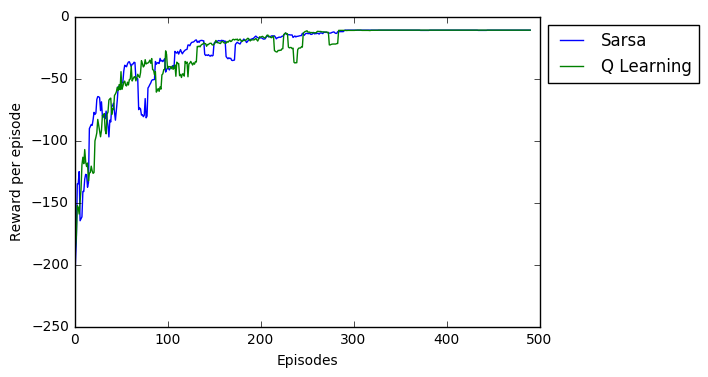

SARSA POLICY:
[['S' 'E' 'W' 'E' 'E' 'E' 'E' 'E' 'N' 'E' 'E' 'S']
 ['S' 'E' 'S' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']]
SARSA POLICY:
[['S' 'E' 'W' 'E' 'E' 'E' 'E' 'E' 'N' 'E' 'E' 'S']
 ['S' 'E' 'S' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S' 'S']
 ['E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'E' 'S']
 ['N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'N']]


In [58]:
def env_step(s, a):
    s_ = s
    if a == 0: #N
        if s[0] > 0:
            s_ = (s[0]-1, s[1])
    elif a == 1: #S
        if s[0] < 3:
            s_ = (s[0]+1, s[1])
    elif a == 2: #E
        if s[1] < 11:
            s_ = (s[0], s[1]+1)
    elif a == 3: #W
        if s[1] > 0:
            s_ = (s[0], s[1]-1)
    else:
        raise ValueError("a must be between 0 and 3 inclusive, but is {}".format(a))
        
    done = False
    if s_ == (3, 11):
        r = 1
        done = True
    elif s_[0] == 3 and 0 < s_[1]:
        r = -100
        s_ = (3, 0) # back to start
    else:
        r = -1
    
    return s_, r, done


def qlearning(Pi, alpha=0.1, gamma=1, debug=False):
    Q = np.zeros((4,12,4))
    epsilon = 0.05
    E = 500
    max_steps = 100
    rewards = []
    for i in range(E):
        epsilon = epsilon * 0.99
        s = (3, 0)
        reward = 0
        for j in range(max_steps):
            a = Pi(Q, s, epsilon)
            s_, r, done = env_step(s, a)
            if debug:
                print(Q[s], Q[s_])
                print(s, a, r, s_)
            reward += r
            a_ = Pi(Q, s_, 0)
            Q[s[0], s[1], a] = (1 - alpha)*Q[s[0], s[1], a] + alpha*(r + gamma*Q[s_[0], s_[1], a_])
            if debug:
                print(Q[s])
            s = s_
            if done:
                break
        
        if debug:
            print(reward)
        rewards.append(reward)
    
    return Q, rewards


def sarsa(Pi, alpha=0.1, gamma=1, debug=False):
    Q = np.zeros((4,12,4))
    epsilon = 0.05
    E = 500
    max_steps = 100
    rewards = []
    for i in range(E):
        epsilon = epsilon * 0.99
        s = (3, 0)
        a = Pi(Q, s, epsilon)
        reward = 0
        for j in range(max_steps):
            s_, r, done = env_step(s, a)
            if debug:
                print(Q[s], Q[s_])
                print(s, a, r, s_)
            reward += r
            a_ = Pi(Q, s_, epsilon)
            Q[s[0], s[1], a] = (1 - alpha)*Q[s[0], s[1], a] + alpha*(r + gamma*Q[s_[0], s_[1], a_])
            if debug:
                print(Q[s])
            s = s_
            a = a_
            if done:
                break
        
        if debug:
            print(reward)
        rewards.append(reward)
    
    return Q, rewards

def epsilon_greedy(Q, s, epsilon):
    if np.random.rand() < epsilon:
        a = np.random.randint(0,4)
    else:
        a_s = np.argwhere(Q[s] == np.max(Q[s]))
        a = np.random.choice(a_s.flatten())
        
    return a

# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean/27681394#27681394
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

def a_to_char(a):
    if a == 0:
        return 'N'
    elif a == 1:
        return 'S'
    elif a == 2:
        return 'E'
    elif a == 3:
        return 'W'


np.random.seed(0)
sarsa_V, sarsa_rewards = sarsa(epsilon_greedy, debug=False)
q_V, q_rewards = qlearning(epsilon_greedy, debug=False)
plt.plot(running_mean(sarsa_rewards, 10), label="Sarsa")
plt.plot(running_mean(q_rewards, 10), label="Q Learning")
plt.ylabel("Reward per episode")
plt.xlabel("Episodes")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()

print("SARSA POLICY:")
pfunc = np.vectorize(a_to_char)
print(pfunc(np.argmax(sarsa_V, axis=2)))
print("SARSA POLICY:")
print(pfunc(np.argmax(sarsa_V, axis=2)))